In [4]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import xgboost as xgb
import joblib

import warnings
warnings.filterwarnings('ignore') 

In [5]:
data = pd.read_excel(r"C:\Users\asnav\OneDrive\Documents\MachineLearningProjects\url_phishing_detection\data\dataset.xlsx")  
df=data.copy()

In [6]:
df.head()

,Labels,URLs
0,1,http://dbs.vote-friend.com/sg?ref=anything
1,0,https://www.reynoldstransfer.com/versa-lift-fo...
2,1,https://www.halisupportservice.com/Login.php
3,0,https://www.signets.com.br/wp-includes/wlwmani...
4,1,https://docs.google.com/document/d/e/2PACX-1vT...


In [7]:
df.tail()

,Labels,URLs
19995,1,https://messagerievocale56.wixsite.com/orange
19996,1,https://06e6f4d3bb4140516.temporary.link/pt/DS...
19997,1,http://lbcpszonaseguravialbcp.cub-medisc.com/1...
19998,0,https://dljproduce.com/produce-commodity-calen...
19999,0,https://www.vineinternational.org/team


In [8]:
df.shape

(20000, 2)

In [9]:
df.describe()

,Labels
count,20000.000000
mean,0.500000
std,0.500013
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [10]:
df.dtypes

Labels     int64
URLs      object
dtype: object

In [11]:
df.isna().sum()

Labels    0
URLs      0
dtype: int64

In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Labels  20000 non-null  int64 
 1   URLs    20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB
None


In [13]:
print("Label Distribution:")
print(df['Labels'].value_counts())

Label Distribution:
Labels
1    10000
0    10000
Name: count, dtype: int64


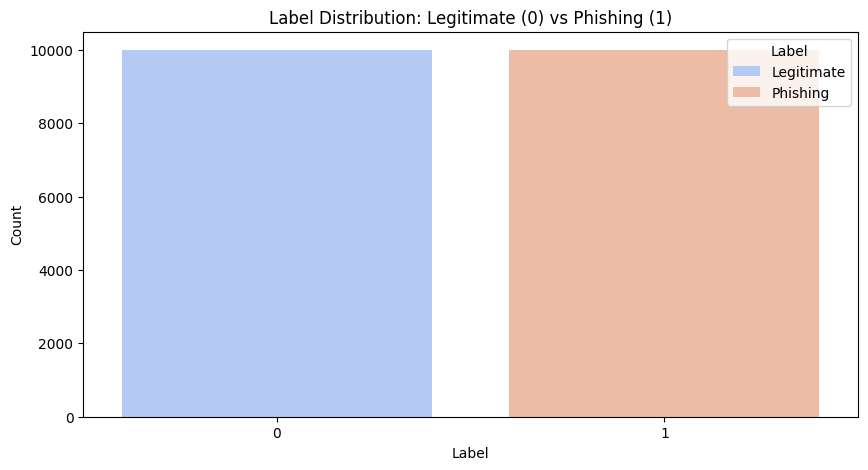

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(x='Labels', data=df, palette='coolwarm')
plt.title('Label Distribution: Legitimate (0) vs Phishing (1)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.legend(title='Label', labels=['Legitimate', 'Phishing'])
plt.show()

In [15]:
def preprocess_url(url):
    url = str(url).strip().lower()
    return url

In [16]:
def get_domain(url):
    parsed = urlparse(url)
    domain = parsed.netloc.lower()
    if domain.startswith('www.'):
        domain = domain[4:]
    return domain

def count_subdomains(domain):
    return len(domain.split('.')) - 1

def has_ip(domain):
    return bool(re.match(r'\d+\.\d+\.\d+\.\d+', domain))

def has_suspicious_words(url):
    suspicious = ['login', 'signin', 'verify', 'secure', 'account', 
                  'update', 'confirm', 'banking', 'password', 'credential']
    return any(word in url.lower() for word in suspicious)

def has_suspicious_tld(domain):
    suspicious_tlds = ['.tk', '.ml', '.ga', '.cf', '.gq', '.xyz']
    return any(domain.endswith(tld) for tld in suspicious_tlds)

def extract_features(url):
    trusted_domains = {
    'google.com', 'youtube.com', 'github.com', 'microsoft.com', 'amazon.com',
    'facebook.com', 'twitter.com', 'linkedin.com', 'apple.com', 'yahoo.com',
    'wikipedia.org', 'instagram.com', 'paypal.com', 'bankofamerica.com', 'chase.com',
    'paypal.com', 'vimeo.com', 'netflix.com', 'microsoftonline.com', 'dropbox.com',
    'slack.com', 'ebay.com', 'bing.com', 'zoom.us', 'shopify.com',
    'reddit.com', 'snapchat.com', 'pinterest.com', 'wordpress.org', 'twitch.tv',
    'airbnb.com', 'expedia.com', 'capitalone.com', 'wellsfargo.com', 'adobe.com',
    'coursera.org', 'bbc.com', 'cnn.com', 'forbes.com', 'nytimes.com',
    'bbc.co.uk', 'theguardian.com', 'huffpost.com', 'businessinsider.com', 'usatoday.com',
    'cloudflare.com', 'docker.com', 'heroku.com', 'salesforce.com', 'oracle.com',
    'zoom.com', 'trello.com', 'zendesk.com', 'mailchimp.com', 'canva.com',
    'bitbucket.org', 'gitlab.com', 'strava.com', 'medium.com', 'aircanada.com'
}


    url = preprocess_url(url)
    parsed = urlparse(url)
    domain = get_domain(url)
    
    features = {
        'domain_length': len(domain),
        'is_trusted_domain': int(domain in trusted_domains),
        'subdomain_count': count_subdomains(domain),
        'has_www': int(parsed.netloc.startswith('www.')),
        'url_length': len(url),
        'path_length': len(parsed.path),
        'query_length': len(parsed.query),
        'fragment_length': len(parsed.fragment),
        'path_depth': len([x for x in parsed.path.split('/') if x]),
        'dots_count': domain.count('.'),
        'digits_count': sum(c.isdigit() for c in url),
        'special_chars_count': sum(not c.isalnum() for c in url),
        'has_ip_address': int(has_ip(domain)),
        'has_at_symbol': int('@' in url),
        'has_double_slash': int('//' in parsed.path),
        'has_dash_in_domain': int('-' in domain),
        'has_https': int(url.startswith('https://')),
        'has_suspicious_words': int(has_suspicious_words(url)),
        'excessive_subdomains': int(count_subdomains(domain) > 3),
        'suspicious_tld': int(has_suspicious_tld(domain))
    }
    return features


In [17]:
features_df = df['URLs'].apply(extract_features).apply(pd.Series)
final_df = pd.concat([features_df, df['Labels']], axis=1)
final_df.head()


,domain_length,is_trusted_domain,subdomain_count,has_www,url_length,path_length,query_length,fragment_length,path_depth,dots_count,...,special_chars_count,has_ip_address,has_at_symbol,has_double_slash,has_dash_in_domain,has_https,has_suspicious_words,excessive_subdomains,suspicious_tld,Labels
0,19,0,2,0,42,3,12,0,1,2,...,9,0,0,0,1,0,0,0,0,1
1,20,0,1,1,55,23,0,0,1,1,...,10,0,0,0,0,1,0,0,0,0
2,22,0,1,1,44,10,0,0,1,1,...,7,0,0,0,0,1,1,0,0,1
3,14,0,2,1,54,28,0,0,2,2,...,10,0,0,0,0,1,0,0,0,0
4,15,0,2,0,141,104,13,0,5,2,...,15,0,0,0,0,1,0,0,0,1


In [18]:
final_df.tail()

,domain_length,is_trusted_domain,subdomain_count,has_www,url_length,path_length,query_length,fragment_length,path_depth,dots_count,...,special_chars_count,has_ip_address,has_at_symbol,has_double_slash,has_dash_in_domain,has_https,has_suspicious_words,excessive_subdomains,suspicious_tld,Labels
19995,30,0,2,0,45,7,0,0,1,2,...,6,0,0,0,0,1,0,0,0,1
19996,32,0,2,0,76,36,0,0,3,2,...,8,0,0,0,0,1,0,0,0,1
19997,37,0,2,0,70,26,0,0,2,2,...,9,0,0,0,1,0,0,0,0,1
19998,14,0,1,0,50,28,0,0,1,1,...,8,0,0,0,0,1,0,0,0,0
19999,21,0,1,1,38,5,0,0,1,1,...,6,0,0,0,0,1,0,0,0,0


In [19]:
final_df.shape

(20000, 21)

In [20]:
final_df.dtypes

domain_length           int64
is_trusted_domain       int64
subdomain_count         int64
has_www                 int64
url_length              int64
path_length             int64
query_length            int64
fragment_length         int64
path_depth              int64
dots_count              int64
digits_count            int64
special_chars_count     int64
has_ip_address          int64
has_at_symbol           int64
has_double_slash        int64
has_dash_in_domain      int64
has_https               int64
has_suspicious_words    int64
excessive_subdomains    int64
suspicious_tld          int64
Labels                  int64
dtype: object

In [21]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   domain_length         20000 non-null  int64
 1   is_trusted_domain     20000 non-null  int64
 2   subdomain_count       20000 non-null  int64
 3   has_www               20000 non-null  int64
 4   url_length            20000 non-null  int64
 5   path_length           20000 non-null  int64
 6   query_length          20000 non-null  int64
 7   fragment_length       20000 non-null  int64
 8   path_depth            20000 non-null  int64
 9   dots_count            20000 non-null  int64
 10  digits_count          20000 non-null  int64
 11  special_chars_count   20000 non-null  int64
 12  has_ip_address        20000 non-null  int64
 13  has_at_symbol         20000 non-null  int64
 14  has_double_slash      20000 non-null  int64
 15  has_dash_in_domain    20000 non-null  int64
 16  has_

In [22]:
final_df.describe()

,domain_length,is_trusted_domain,subdomain_count,has_www,url_length,path_length,query_length,fragment_length,path_depth,dots_count,...,special_chars_count,has_ip_address,has_at_symbol,has_double_slash,has_dash_in_domain,has_https,has_suspicious_words,excessive_subdomains,suspicious_tld,Labels
count,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,18.100900,0.004500,1.451200,0.53860,62.357350,20.940800,12.795300,0.328950,1.71965,1.451200,...,9.908800,0.012000,0.022350,0.002100,0.210550,0.769700,0.125450,0.028850,0.025550,0.500000
std,10.080203,0.066933,0.781504,0.49852,76.724648,23.382879,69.204677,14.134473,1.50405,0.781504,...,9.130435,0.108888,0.147823,0.045779,0.407709,0.421035,0.331237,0.167389,0.157792,0.500013
min,4.000000,0.000000,1.000000,0.00000,14.000000,0.000000,0.000000,0.000000,0.00000,1.000000,...,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,0.000000,1.000000,0.00000,35.000000,8.000000,0.000000,0.000000,1.00000,1.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,16.000000,0.000000,1.000000,1.00000,45.000000,15.000000,0.000000,0.000000,1.00000,1.000000,...,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.500000
75%,21.000000,0.000000,2.000000,1.00000,63.000000,27.000000,0.000000,0.000000,2.00000,2.000000,...,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,151.000000,1.000000,15.000000,1.00000,2206.000000,625.000000,1566.000000,1867.000000,20.00000,15.000000,...,662.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


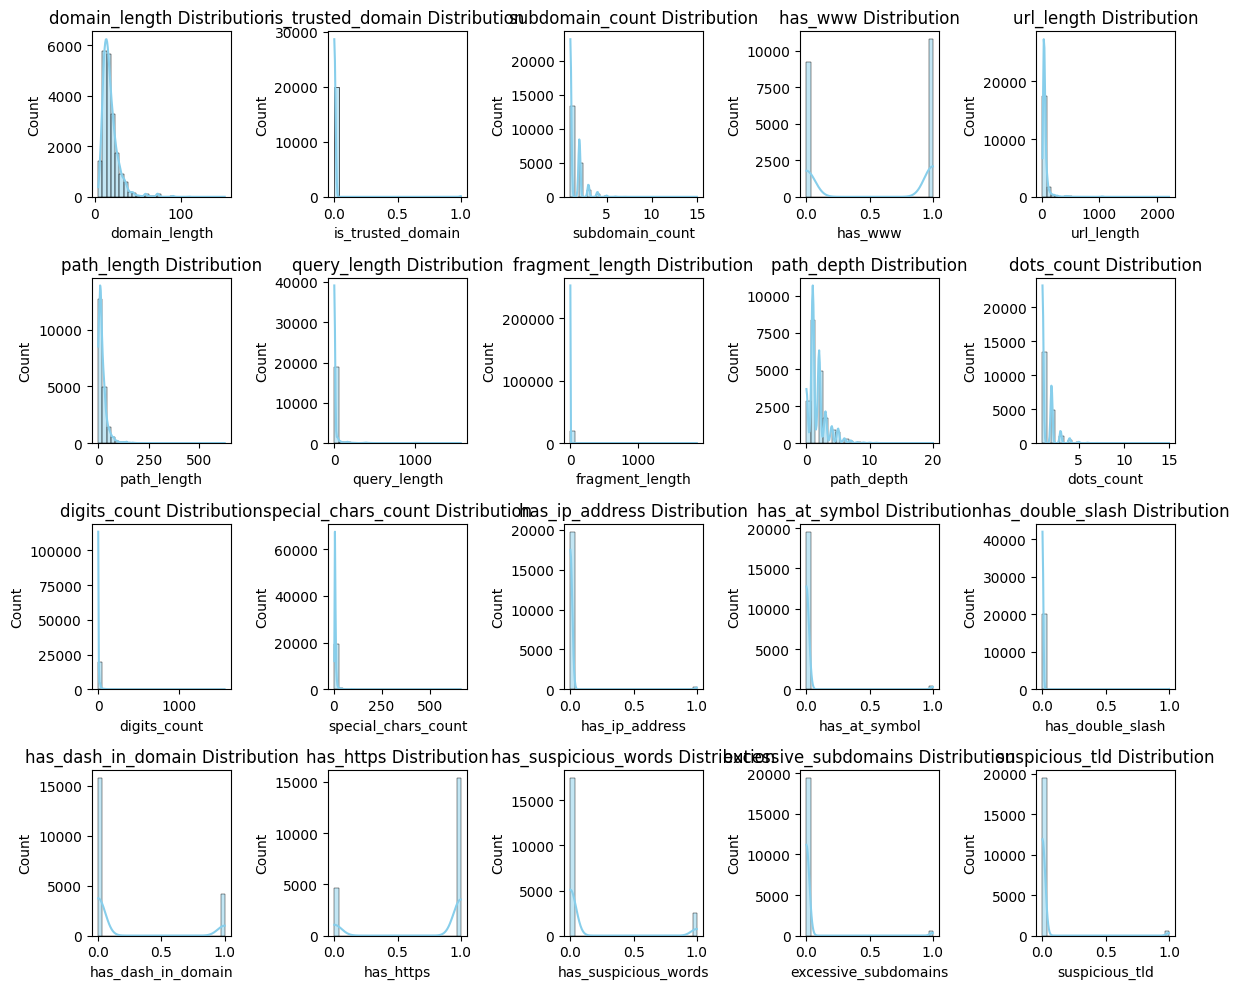

In [23]:
features = final_df.drop(columns=['Labels']).columns  # Exclude 'Labels' for the feature analysis
# Plot histograms for relevant features
plt.figure(figsize=(12, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 5, i)
    sns.histplot(final_df[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'{feature} Distribution')
    plt.tight_layout()
plt.show()

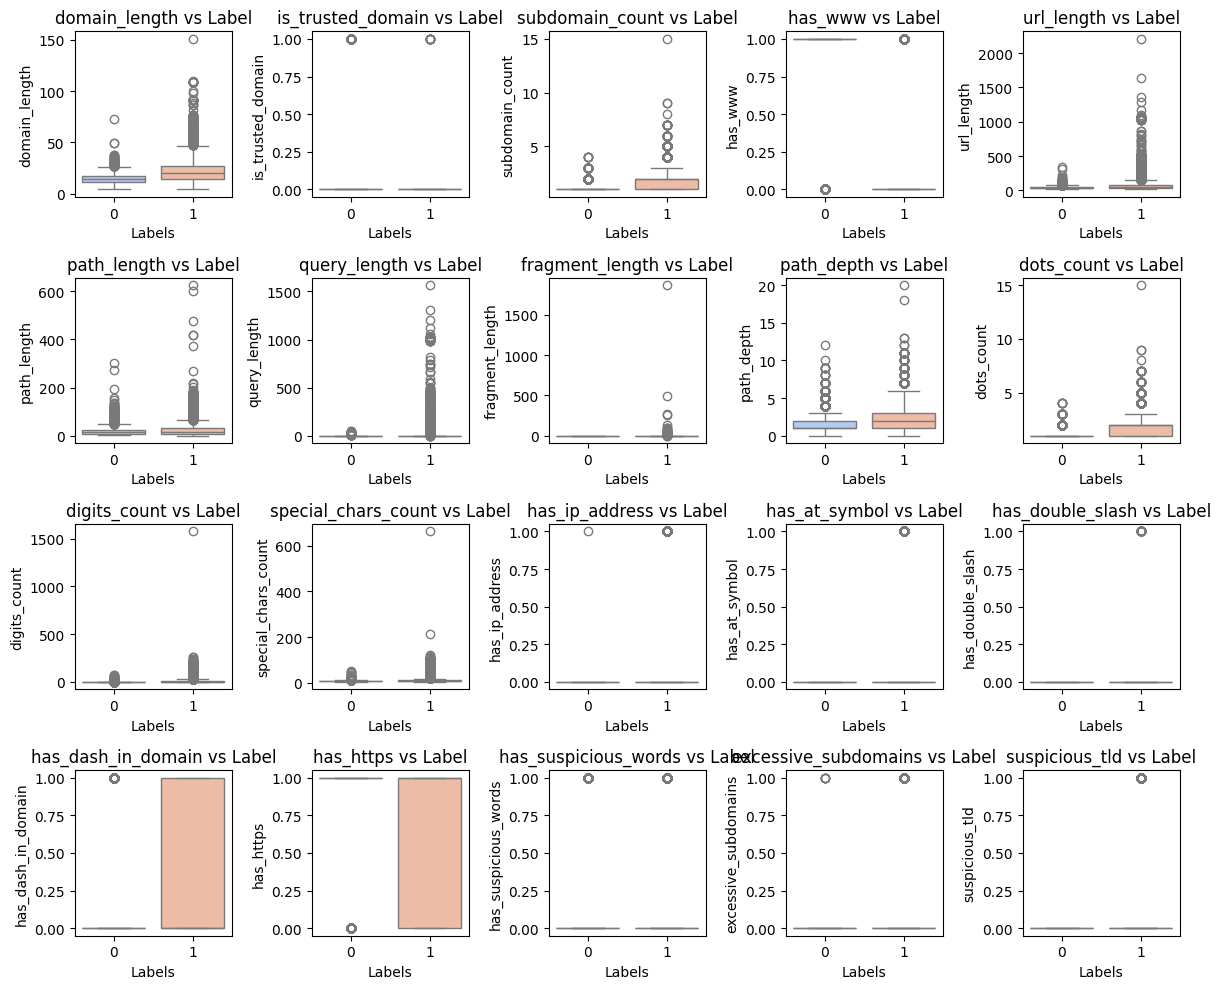

In [24]:
# Plot relationships between features and the target (Labels)
plt.figure(figsize=(12, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 5, i)
    sns.boxplot(x='Labels', y=feature, data=final_df, palette='coolwarm')
    plt.title(f'{feature} vs Label')
    plt.tight_layout()
plt.show()

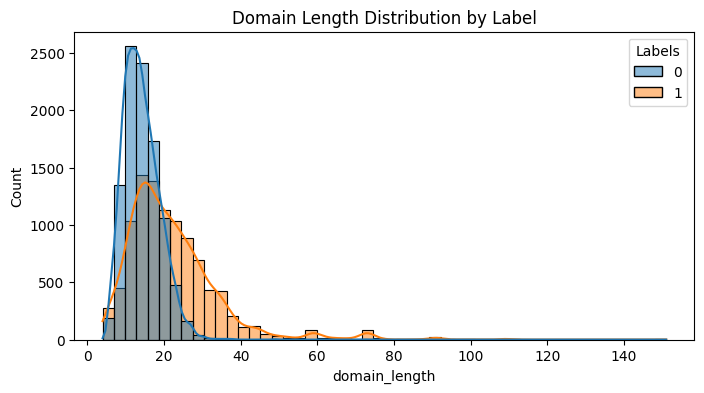

In [25]:
plt.figure(figsize=(8, 4))
sns.histplot(data=final_df, x='domain_length', hue='Labels', bins=50, kde=True)
plt.title("Domain Length Distribution by Label")
plt.show()

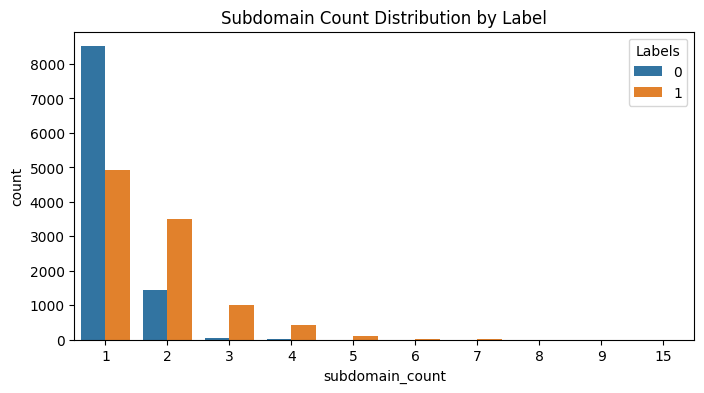

In [26]:
plt.figure(figsize=(8, 4))
sns.countplot(data=final_df, x='subdomain_count', hue='Labels')
plt.title("Subdomain Count Distribution by Label")
plt.show()


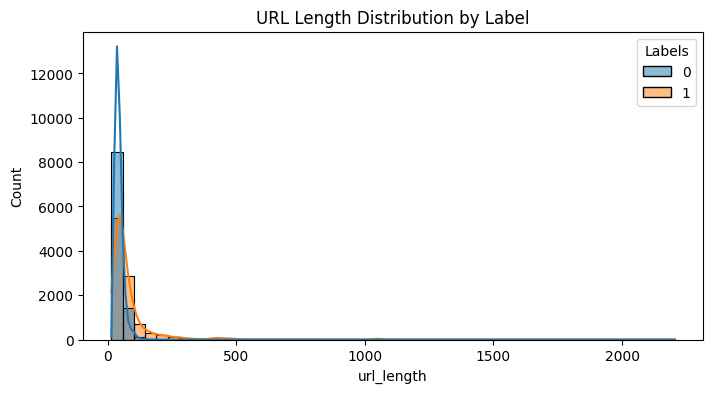

In [27]:
plt.figure(figsize=(8, 4))
sns.histplot(data=final_df, x='url_length', hue='Labels', bins=50, kde=True)
plt.title("URL Length Distribution by Label")
plt.show()

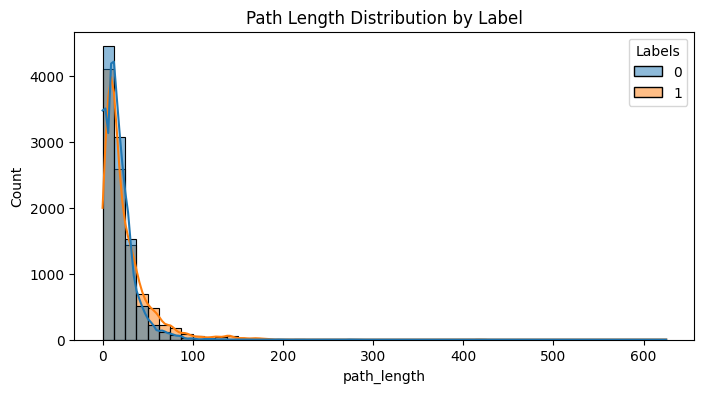

In [28]:
plt.figure(figsize=(8, 4))
sns.histplot(data=final_df, x='path_length', hue='Labels', bins=50, kde=True)
plt.title("Path Length Distribution by Label")
plt.show()

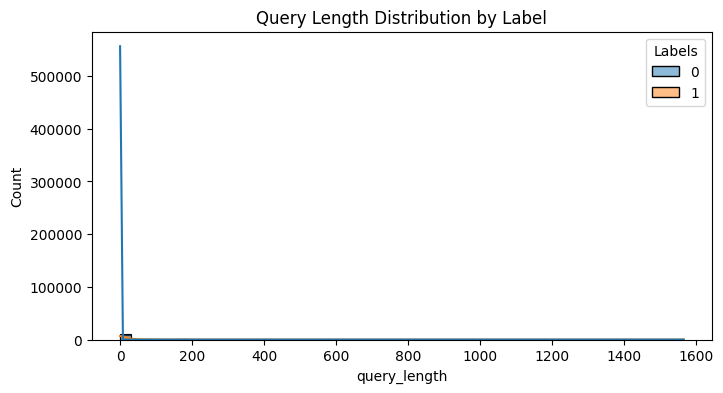

In [29]:
plt.figure(figsize=(8, 4))
sns.histplot(data=final_df, x='query_length', hue='Labels', bins=50, kde=True)
plt.title("Query Length Distribution by Label")
plt.show()

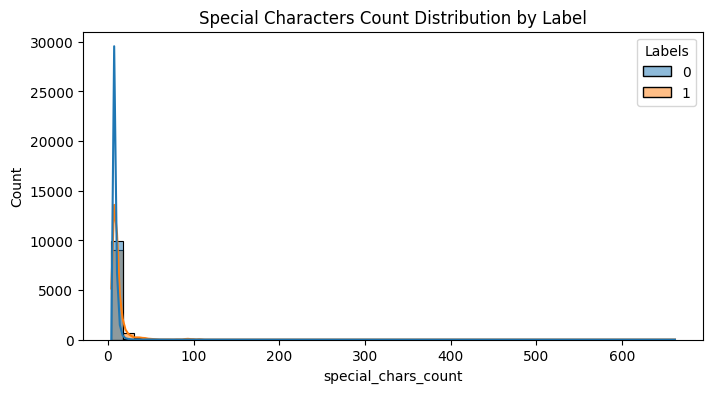

In [30]:
plt.figure(figsize=(8, 4))
sns.histplot(data=final_df, x='special_chars_count', hue='Labels', bins=50, kde=True)
plt.title("Special Characters Count Distribution by Label")
plt.show()

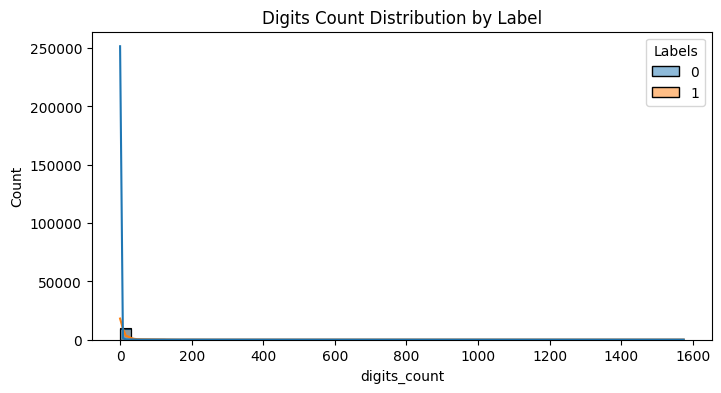

In [31]:
plt.figure(figsize=(8, 4))
sns.histplot(data=final_df, x='digits_count', hue='Labels', bins=50, kde=True)
plt.title("Digits Count Distribution by Label")
plt.show()

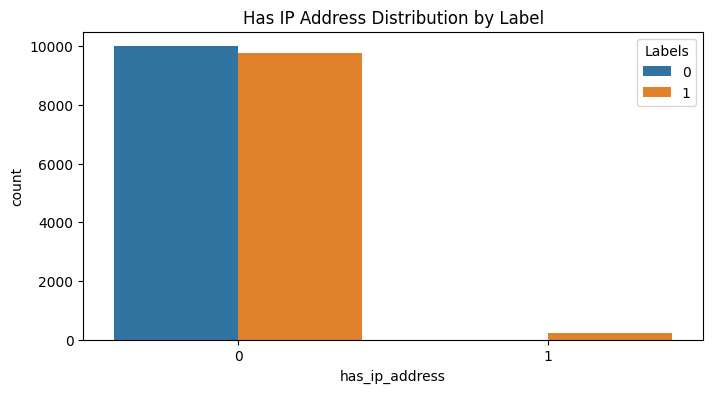

In [32]:
plt.figure(figsize=(8, 4))
sns.countplot(data=final_df, x='has_ip_address', hue='Labels')
plt.title("Has IP Address Distribution by Label")
plt.show()

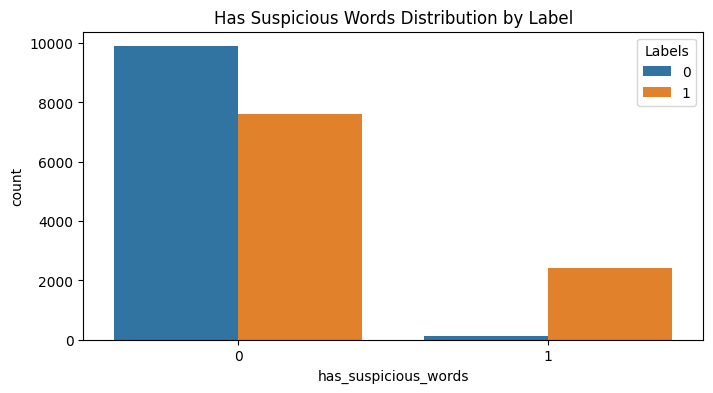

In [33]:
plt.figure(figsize=(8, 4))
sns.countplot(data=final_df, x='has_suspicious_words', hue='Labels')
plt.title("Has Suspicious Words Distribution by Label")
plt.show()

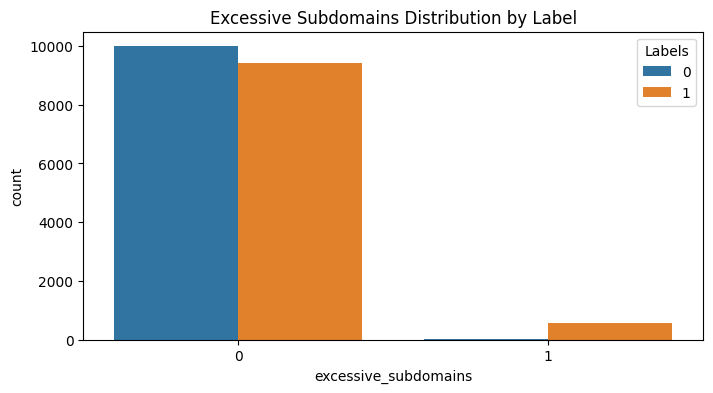

In [34]:
plt.figure(figsize=(8, 4))
sns.countplot(data=final_df, x='excessive_subdomains', hue='Labels')
plt.title("Excessive Subdomains Distribution by Label")
plt.show()

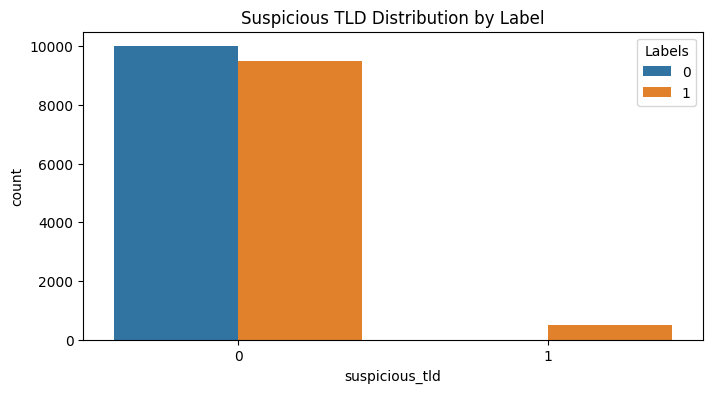

In [35]:
plt.figure(figsize=(8, 4))
sns.countplot(data=final_df, x='suspicious_tld', hue='Labels')
plt.title("Suspicious TLD Distribution by Label")
plt.show()

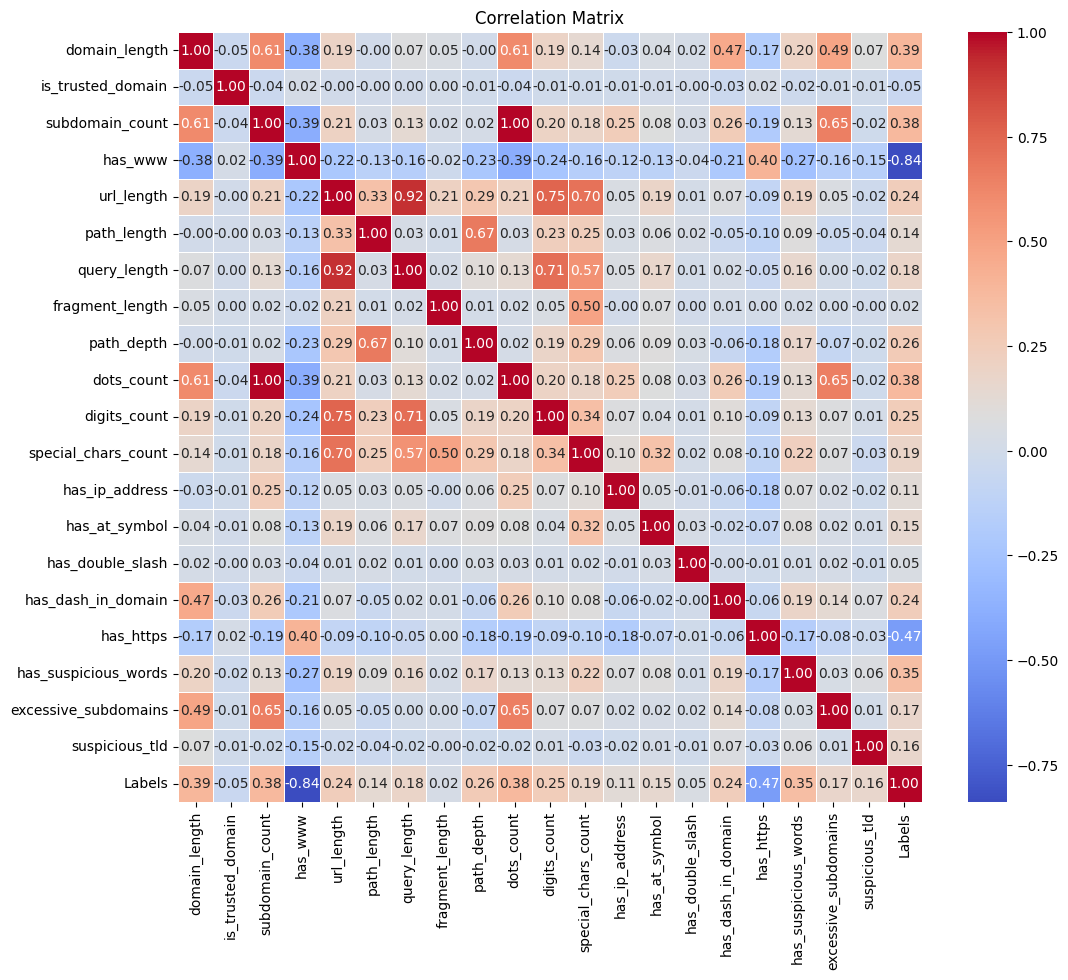

In [36]:
# Compute correlation matrix for features and plot a heatmap
correlation_matrix = final_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [37]:
scaler = StandardScaler()
scaled_df = final_df.copy()
scaled_df[['url_length', 'domain_length', 'path_length', 'query_length', 
           'path_depth', 'dots_count', 'digits_count', 'special_chars_count']] = scaler.fit_transform(
               scaled_df[['url_length', 'domain_length', 'path_length', 'query_length', 
                          'path_depth', 'dots_count', 'digits_count', 'special_chars_count']])


In [38]:
# Step 6: Train-Test Split
X = final_df.drop('Labels', axis=1)
y = final_df['Labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


✅ Accuracy: 0.9625

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      2004
           1       0.96      0.97      0.96      1996

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



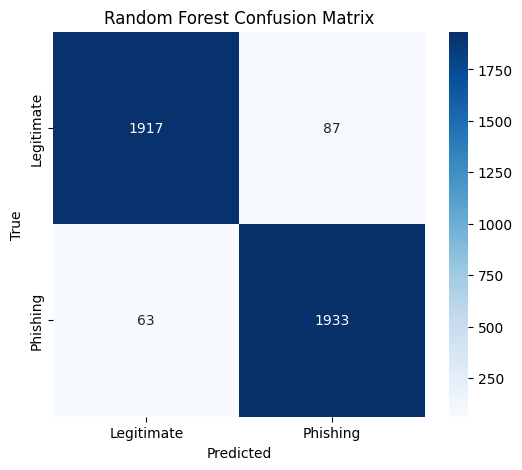

In [39]:
# ----- Model Training -----
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))


# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



✅ Logistic Regression Accuracy: 0.95075

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      2004
           1       0.95      0.95      0.95      1996

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



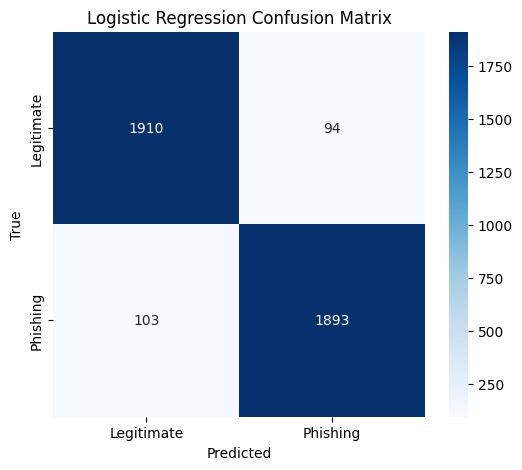

In [40]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression Model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Accuracy & Classification Report
print("\n✅ Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



✅ SVM Accuracy: 0.93525

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      2004
           1       0.95      0.92      0.93      1996

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



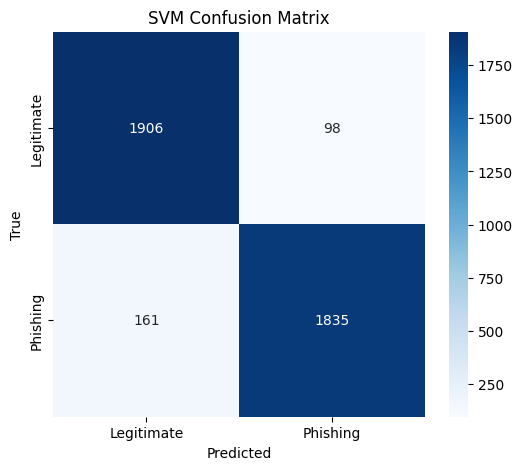

In [41]:
from sklearn.svm import SVC

# SVM Model
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test)

# Accuracy & Classification Report
print("\n✅ SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred_svm))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



✅ KNN Accuracy: 0.94175

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      2004
           1       0.95      0.93      0.94      1996

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



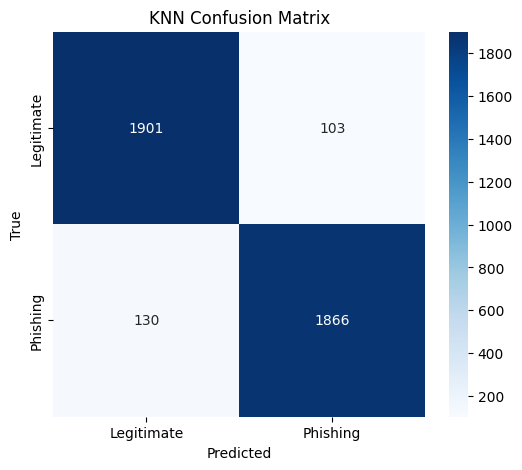

In [42]:
from sklearn.neighbors import KNeighborsClassifier

# KNN Model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Predictions
y_pred_knn = knn_model.predict(X_test)

# Accuracy & Classification Report
print("\n✅ KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred_knn))

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [43]:
# from sklearn.model_selection import GridSearchCV


# param_grid = {'max_depth': [3, 5, 7, 10], 'n_estimators': [100, 200, 500]}
# grid_search = GridSearchCV(model, param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best Accuracy:", grid_search.best_score_)

"""
Best Parameters: {'max_depth': 10, 'n_estimators': 500}
Best Accuracy: 0.9578749999999999
"""

"\nBest Parameters: {'max_depth': 10, 'n_estimators': 500}\nBest Accuracy: 0.9578749999999999\n"


✅ Accuracy: 0.962

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      2004
           1       0.96      0.97      0.96      1996

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



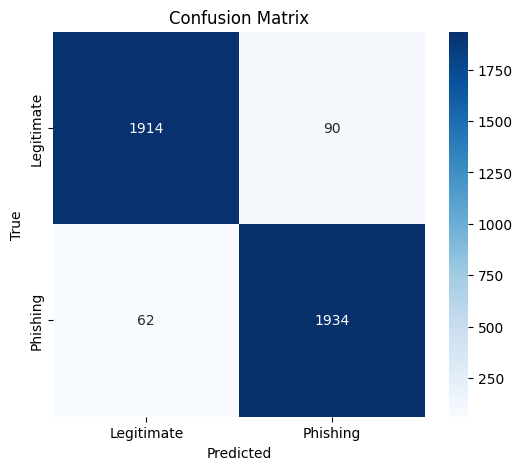

In [44]:
model = RandomForestClassifier(max_depth=10,n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [45]:
def predict_url(url):
    features = extract_features(url)
    features_df = pd.DataFrame([features])  # Convert dict → single row DataFrame
    result = model.predict(features_df)[0]
    return "Phishing" if result == 1 else "Legitimate"


In [46]:
test_url = "http://free-login-update.com/account/verify"
print(f"\n🔎 Test URL Prediction → {test_url} → {predict_url(test_url)}")


🔎 Test URL Prediction → http://free-login-update.com/account/verify → Phishing


In [47]:
test_url = "https://www.google.com"
print(f"\n🔎 Test URL Prediction → {test_url} → {predict_url(test_url)}")


🔎 Test URL Prediction → https://www.google.com → Legitimate


In [50]:
joblib.dump(model,r'C:\Users\asnav\OneDrive\Documents\MachineLearningProjects\url_phishing_detection\model\phishing_model.pkl')

['C:\\Users\\asnav\\OneDrive\\Documents\\MachineLearningProjects\\url_phishing_detection\\model\\phishing_model.pkl']

In [51]:
final_df.columns

Index(['domain_length', 'is_trusted_domain', 'subdomain_count', 'has_www',
       'url_length', 'path_length', 'query_length', 'fragment_length',
       'path_depth', 'dots_count', 'digits_count', 'special_chars_count',
       'has_ip_address', 'has_at_symbol', 'has_double_slash',
       'has_dash_in_domain', 'has_https', 'has_suspicious_words',
       'excessive_subdomains', 'suspicious_tld', 'Labels'],
      dtype='object')